# Quest08: Segmentation map으로 도로 이미지 만들기

### 평가문항에 맞춰서 작성
**1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.**  
-> 데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.

**2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.**  
-> U-Net generator, discriminator 모델 구현이 완료되어 train_step의 output을 확인하고 개선하였다.

**3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.**  
-> 10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.

# Import

In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers


# gpu 환경설정

In [29]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 메모리 사용 제한을 위한 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # 특정 GPU만 사용하도록 설정
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
        # 런타임 오류 발생 시 예외 처리가 필요함
        print(e)

Physical devices cannot be modified after being initialized


In [26]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


---

# <span style="background-color:#E6E6FA">  1. 도로 이미지 데이터셋 가져오기</span>

In [2]:
data_path = os.getenv('HOME')+'/aiffel/segmentation_map/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


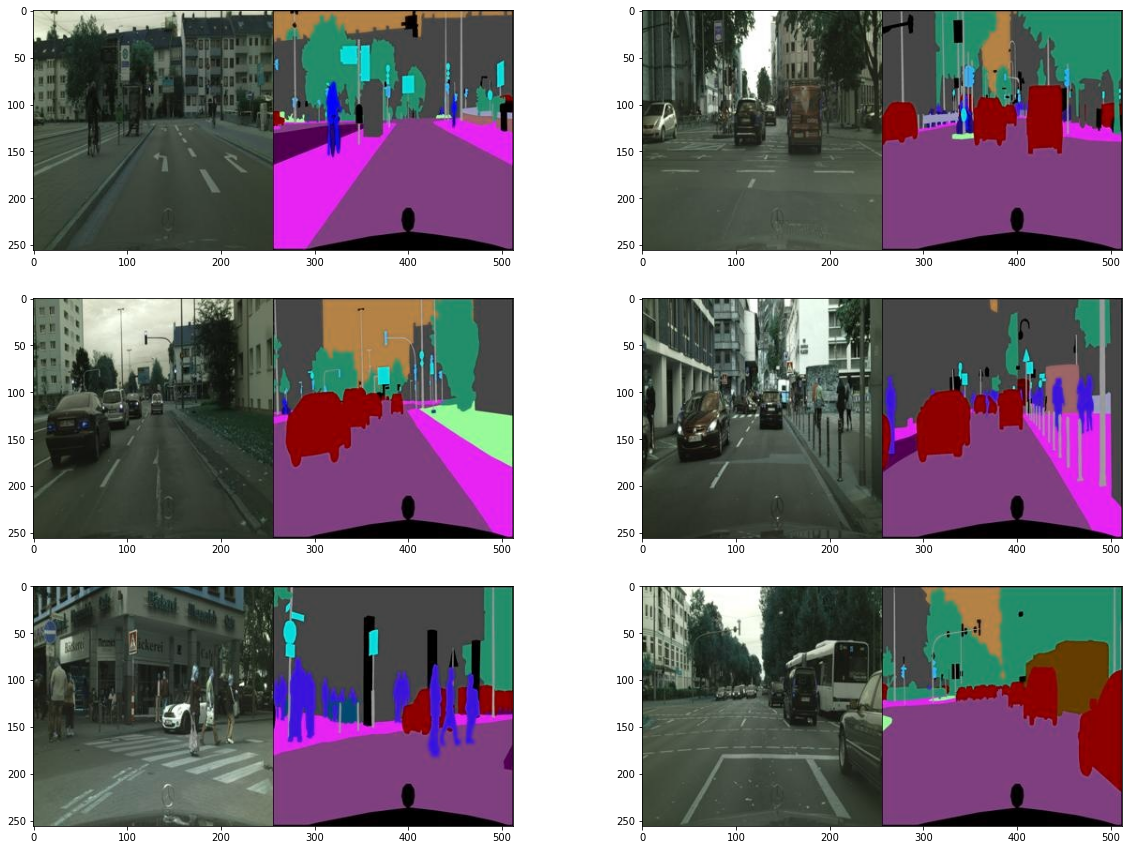

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

---

# <span style="background-color:#E6E6FA">  2. 데이터 확인 및 전처리</span>

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


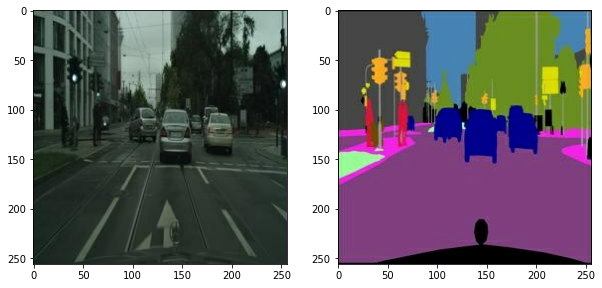

In [5]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
colored, sketch = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

---

# <span style="background-color:#E6E6FA">  3. 데이터에 한 가지 이상의 augmentation 방법을 적용  </span>

In [6]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]

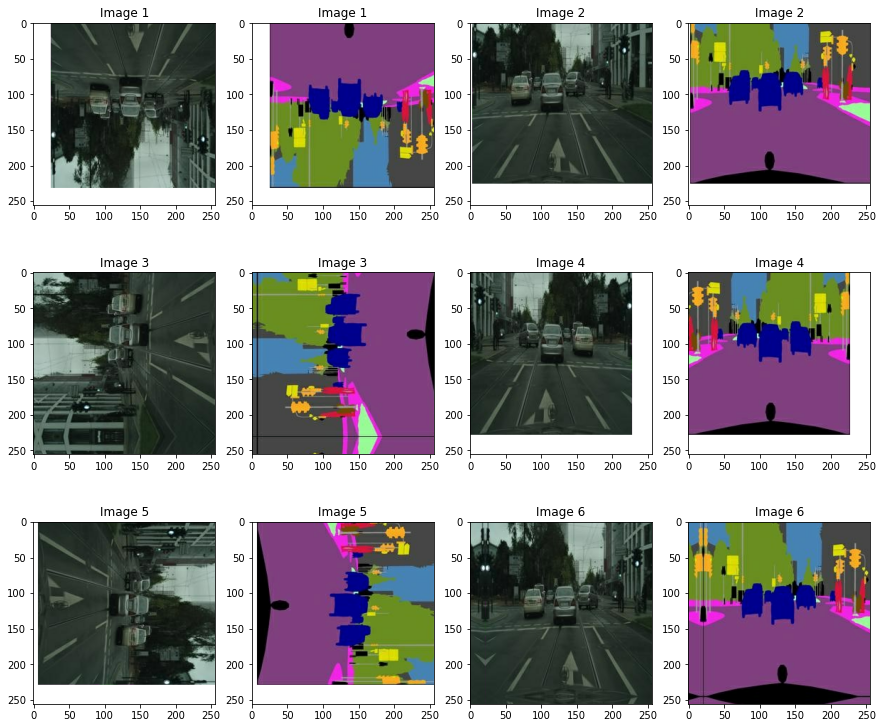

In [7]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

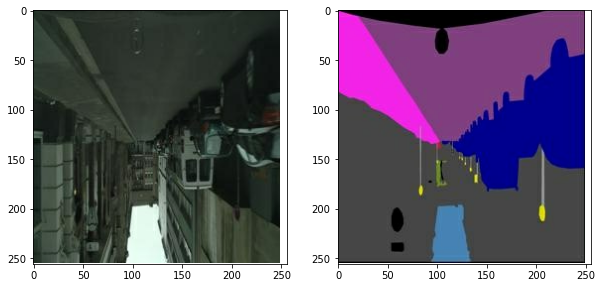

In [32]:
from tensorflow import data

def get_train(img_path):
    colored, sketch = load_img(img_path)
    colored, sketch = apply_augmentation(sketch, colored)
    return colored, sketch

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
colored, sketch = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

---

# <span style="background-color:#E6E6FA">  4.  U-Net Generator를 사용 </span>

In [9]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [10]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [11]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

---

# <span style="background-color:#E6E6FA">  5. Discriminator 구현하기 </span>

In [12]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [13]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [14]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()

        filters = [64,128,256,512,1]
        self.blocks = [layers.Concatenate()]
        # For문을 활용해서 DiscBlock을 쌓아주세요.
        # 조건 1 : 3번째까지 stride는 2로 주되 이후에는 1로 주세요
        # 조건 2 : 3번째까지 custom padding을 주지 않아도 되는데 이후에는 주세요.
        # 조건 3: 1번째와 5번째에서는 Batch Normalization을 사용하지 마세요.
        # 조건 4 : 1번째부터 4번째까지 LeakyReLU를 적용하고 마지막에는 sigmoid를 적용하세요. (sigmoid의 경우 따로 정의해야 합니다)
        for i, f in enumerate(filters):
            self.blocks.append(DiscBlock(
            n_filters=f,
            stride=2 if i < 3 else 1,
            custom_pad= i >= 3,
            use_bn= (i == 1 or i == 4),
            act= i < 4
            ))
        self.sigmoid = layers.Activation(tf.keras.activations.sigmoid)

    def call(self, x, y):
        out = self.blocks[0]([x, y])
        for block in self.blocks[1:]:
            out = block(out)
        return self.sigmoid(out)

    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape)
        return Model((x, y), self.call(x, y)).summary()

In [15]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

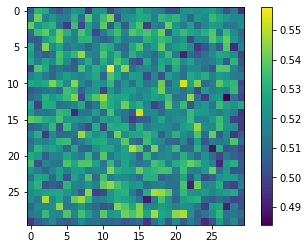

In [16]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

---

# <span style="background-color:#E6E6FA">  6. 학습된 Generator를 이용해 테스트 </span>

In [34]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    total_gen_loss = gene_loss + (100 * l1_loss) # <<< total 값 추가 이 값으로 gradient를 계산해야 학습이 정상적으로 진행됨.!!!!
    return total_gen_loss, gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [18]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [19]:
# 가중치를 1회 업데이트

generator = UNetGenerator()
discriminator = Discriminator()

@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
    # 이전에 배웠던 내용을 토대로 train_step을 구성해주세요.
        # Generator에 Sketch를 입력하여 생성된 이미지를 얻습니다.
        generated_colored = generator(sketch, training=True)

        # Discriminator에 실제 컬러 이미지와 생성된 컬러 이미지를 입력합니다.
        real_disc = discriminator(real_colored, sketch, training=True)
        fake_disc = discriminator(generated_colored, sketch, training=True)

        # Generator의 손실, Loss를 계산합니다.
        total_gen_loss, gene_loss, l1_loss = get_gene_loss(generated_colored, real_colored, fake_disc)

        # Discriminator의 손실을 계산합니다.
        disc_loss = get_disc_loss(fake_disc, real_disc)

    # Generator와 Discriminator의 Gradient를 계산합니다.
    gene_gradient = gene_tape.gradient(total_gen_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return total_gen_loss, l1_loss, disc_loss

In [20]:
EPOCHS = 100

step_check = []
loss_check = []

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        total_gen_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nTotal_gen_loss:{total_gen_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
            
            step_check.append(epoch*(i+1))
            loss_check.append(round(total_gen_loss.numpy(),2))

EPOCH[1] - STEP[10]                     
Total_gen_loss:34.6741                     
L1_loss:0.3391                     
Discriminator_loss:1.5400

EPOCH[1] - STEP[20]                     
Total_gen_loss:29.0076                     
L1_loss:0.2824                     
Discriminator_loss:1.5499

EPOCH[1] - STEP[30]                     
Total_gen_loss:28.8300                     
L1_loss:0.2809                     
Discriminator_loss:1.4917

EPOCH[1] - STEP[40]                     
Total_gen_loss:26.2453                     
L1_loss:0.2551                     
Discriminator_loss:1.4765

EPOCH[1] - STEP[50]                     
Total_gen_loss:30.6484                     
L1_loss:0.2989                     
Discriminator_loss:1.5315

EPOCH[1] - STEP[60]                     
Total_gen_loss:26.6302                     
L1_loss:0.2590                     
Discriminator_loss:1.4773

EPOCH[1] - STEP[70]                     
Total_gen_loss:21.7518                     
L1_loss:0.2101             

EPOCH[3] - STEP[70]                     
Total_gen_loss:22.8259                     
L1_loss:0.2212                     
Discriminator_loss:1.4585

EPOCH[3] - STEP[80]                     
Total_gen_loss:19.5053                     
L1_loss:0.1881                     
Discriminator_loss:1.4329

EPOCH[3] - STEP[90]                     
Total_gen_loss:20.2798                     
L1_loss:0.1957                     
Discriminator_loss:1.4654

EPOCH[3] - STEP[100]                     
Total_gen_loss:17.0582                     
L1_loss:0.1633                     
Discriminator_loss:1.4932

EPOCH[3] - STEP[110]                     
Total_gen_loss:22.6510                     
L1_loss:0.2196                     
Discriminator_loss:1.4346

EPOCH[3] - STEP[120]                     
Total_gen_loss:17.2945                     
L1_loss:0.1659                     
Discriminator_loss:1.4644

EPOCH[3] - STEP[130]                     
Total_gen_loss:26.1007                     
L1_loss:0.2541         

EPOCH[5] - STEP[130]                     
Total_gen_loss:16.0542                     
L1_loss:0.1536                     
Discriminator_loss:1.4197

EPOCH[5] - STEP[140]                     
Total_gen_loss:19.4679                     
L1_loss:0.1877                     
Discriminator_loss:1.4287

EPOCH[5] - STEP[150]                     
Total_gen_loss:15.6386                     
L1_loss:0.1495                     
Discriminator_loss:1.4167

EPOCH[5] - STEP[160]                     
Total_gen_loss:19.6556                     
L1_loss:0.1896                     
Discriminator_loss:1.4193

EPOCH[5] - STEP[170]                     
Total_gen_loss:18.1997                     
L1_loss:0.1751                     
Discriminator_loss:1.4243

EPOCH[5] - STEP[180]                     
Total_gen_loss:19.9283                     
L1_loss:0.1924                     
Discriminator_loss:1.4180

EPOCH[5] - STEP[190]                     
Total_gen_loss:24.5972                     
L1_loss:0.2389      

EPOCH[7] - STEP[190]                     
Total_gen_loss:18.4791                     
L1_loss:0.1779                     
Discriminator_loss:1.4154

EPOCH[7] - STEP[200]                     
Total_gen_loss:14.9717                     
L1_loss:0.1428                     
Discriminator_loss:1.4186

EPOCH[7] - STEP[210]                     
Total_gen_loss:18.4151                     
L1_loss:0.1773                     
Discriminator_loss:1.4106

EPOCH[7] - STEP[220]                     
Total_gen_loss:18.7789                     
L1_loss:0.1808                     
Discriminator_loss:1.4214

EPOCH[7] - STEP[230]                     
Total_gen_loss:13.6716                     
L1_loss:0.1297                     
Discriminator_loss:1.4286

EPOCH[7] - STEP[240]                     
Total_gen_loss:18.8053                     
L1_loss:0.1809                     
Discriminator_loss:1.4520

EPOCH[7] - STEP[250]                     
Total_gen_loss:17.2325                     
L1_loss:0.1653      

EPOCH[9] - STEP[250]                     
Total_gen_loss:17.6638                     
L1_loss:0.1697                     
Discriminator_loss:1.4041

EPOCH[10] - STEP[10]                     
Total_gen_loss:16.4996                     
L1_loss:0.1580                     
Discriminator_loss:1.4230

EPOCH[10] - STEP[20]                     
Total_gen_loss:19.5080                     
L1_loss:0.1881                     
Discriminator_loss:1.4068

EPOCH[10] - STEP[30]                     
Total_gen_loss:18.5100                     
L1_loss:0.1781                     
Discriminator_loss:1.4126

EPOCH[10] - STEP[40]                     
Total_gen_loss:20.0394                     
L1_loss:0.1934                     
Discriminator_loss:1.4192

EPOCH[10] - STEP[50]                     
Total_gen_loss:18.0405                     
L1_loss:0.1734                     
Discriminator_loss:1.4196

EPOCH[10] - STEP[60]                     
Total_gen_loss:16.3779                     
L1_loss:0.1568      

EPOCH[12] - STEP[50]                     
Total_gen_loss:14.9358                     
L1_loss:0.1424                     
Discriminator_loss:1.4021

EPOCH[12] - STEP[60]                     
Total_gen_loss:14.9325                     
L1_loss:0.1424                     
Discriminator_loss:1.4109

EPOCH[12] - STEP[70]                     
Total_gen_loss:16.1375                     
L1_loss:0.1544                     
Discriminator_loss:1.4131

EPOCH[12] - STEP[80]                     
Total_gen_loss:17.8055                     
L1_loss:0.1711                     
Discriminator_loss:1.4091

EPOCH[12] - STEP[90]                     
Total_gen_loss:16.2210                     
L1_loss:0.1553                     
Discriminator_loss:1.4108

EPOCH[12] - STEP[100]                     
Total_gen_loss:16.6196                     
L1_loss:0.1592                     
Discriminator_loss:1.4111

EPOCH[12] - STEP[110]                     
Total_gen_loss:18.1687                     
L1_loss:0.1747    

EPOCH[14] - STEP[100]                     
Total_gen_loss:14.5533                     
L1_loss:0.1386                     
Discriminator_loss:1.4020

EPOCH[14] - STEP[110]                     
Total_gen_loss:13.6365                     
L1_loss:0.1294                     
Discriminator_loss:1.4048

EPOCH[14] - STEP[120]                     
Total_gen_loss:14.9217                     
L1_loss:0.1422                     
Discriminator_loss:1.4118

EPOCH[14] - STEP[130]                     
Total_gen_loss:11.9637                     
L1_loss:0.1127                     
Discriminator_loss:1.4097

EPOCH[14] - STEP[140]                     
Total_gen_loss:16.0057                     
L1_loss:0.1531                     
Discriminator_loss:1.4056

EPOCH[14] - STEP[150]                     
Total_gen_loss:22.7005                     
L1_loss:0.2201                     
Discriminator_loss:1.3966

EPOCH[14] - STEP[160]                     
Total_gen_loss:14.3335                     
L1_loss:0.136

EPOCH[16] - STEP[150]                     
Total_gen_loss:11.8659                     
L1_loss:0.1117                     
Discriminator_loss:1.4019

EPOCH[16] - STEP[160]                     
Total_gen_loss:12.3991                     
L1_loss:0.1170                     
Discriminator_loss:1.4024

EPOCH[16] - STEP[170]                     
Total_gen_loss:17.7077                     
L1_loss:0.1701                     
Discriminator_loss:1.4015

EPOCH[16] - STEP[180]                     
Total_gen_loss:13.9342                     
L1_loss:0.1324                     
Discriminator_loss:1.3971

EPOCH[16] - STEP[190]                     
Total_gen_loss:13.1171                     
L1_loss:0.1242                     
Discriminator_loss:1.4025

EPOCH[16] - STEP[200]                     
Total_gen_loss:11.1232                     
L1_loss:0.1043                     
Discriminator_loss:1.3994

EPOCH[16] - STEP[210]                     
Total_gen_loss:14.6605                     
L1_loss:0.139

EPOCH[18] - STEP[200]                     
Total_gen_loss:16.1046                     
L1_loss:0.1540                     
Discriminator_loss:1.4141

EPOCH[18] - STEP[210]                     
Total_gen_loss:15.5649                     
L1_loss:0.1487                     
Discriminator_loss:1.3942

EPOCH[18] - STEP[220]                     
Total_gen_loss:13.1159                     
L1_loss:0.1242                     
Discriminator_loss:1.3973

EPOCH[18] - STEP[230]                     
Total_gen_loss:13.9324                     
L1_loss:0.1324                     
Discriminator_loss:1.3986

EPOCH[18] - STEP[240]                     
Total_gen_loss:14.2588                     
L1_loss:0.1356                     
Discriminator_loss:1.3963

EPOCH[18] - STEP[250]                     
Total_gen_loss:14.9634                     
L1_loss:0.1427                     
Discriminator_loss:1.3966

EPOCH[19] - STEP[10]                     
Total_gen_loss:15.6964                     
L1_loss:0.1500

EPOCH[20] - STEP[250]                     
Total_gen_loss:13.3368                     
L1_loss:0.1264                     
Discriminator_loss:1.3916

EPOCH[21] - STEP[10]                     
Total_gen_loss:16.3773                     
L1_loss:0.1568                     
Discriminator_loss:1.3939

EPOCH[21] - STEP[20]                     
Total_gen_loss:15.6878                     
L1_loss:0.1499                     
Discriminator_loss:1.3917

EPOCH[21] - STEP[30]                     
Total_gen_loss:17.6756                     
L1_loss:0.1698                     
Discriminator_loss:1.3939

EPOCH[21] - STEP[40]                     
Total_gen_loss:10.8321                     
L1_loss:0.1014                     
Discriminator_loss:1.3940

EPOCH[21] - STEP[50]                     
Total_gen_loss:17.6012                     
L1_loss:0.1691                     
Discriminator_loss:1.3951

EPOCH[21] - STEP[60]                     
Total_gen_loss:14.3106                     
L1_loss:0.1362     

EPOCH[23] - STEP[50]                     
Total_gen_loss:12.9136                     
L1_loss:0.1222                     
Discriminator_loss:1.3961

EPOCH[23] - STEP[60]                     
Total_gen_loss:14.5038                     
L1_loss:0.1381                     
Discriminator_loss:1.3913

EPOCH[23] - STEP[70]                     
Total_gen_loss:13.1296                     
L1_loss:0.1244                     
Discriminator_loss:1.3907

EPOCH[23] - STEP[80]                     
Total_gen_loss:9.8220                     
L1_loss:0.0913                     
Discriminator_loss:1.3914

EPOCH[23] - STEP[90]                     
Total_gen_loss:16.3562                     
L1_loss:0.1566                     
Discriminator_loss:1.3907

EPOCH[23] - STEP[100]                     
Total_gen_loss:17.9743                     
L1_loss:0.1728                     
Discriminator_loss:1.3904

EPOCH[23] - STEP[110]                     
Total_gen_loss:11.6950                     
L1_loss:0.1100     

EPOCH[25] - STEP[100]                     
Total_gen_loss:14.3506                     
L1_loss:0.1366                     
Discriminator_loss:1.3885

EPOCH[25] - STEP[110]                     
Total_gen_loss:14.6799                     
L1_loss:0.1399                     
Discriminator_loss:1.3883

EPOCH[25] - STEP[120]                     
Total_gen_loss:10.4668                     
L1_loss:0.0977                     
Discriminator_loss:1.3889

EPOCH[25] - STEP[130]                     
Total_gen_loss:14.6020                     
L1_loss:0.1391                     
Discriminator_loss:1.3884

EPOCH[25] - STEP[140]                     
Total_gen_loss:14.5679                     
L1_loss:0.1387                     
Discriminator_loss:1.3883

EPOCH[25] - STEP[150]                     
Total_gen_loss:17.4937                     
L1_loss:0.1680                     
Discriminator_loss:1.3884

EPOCH[25] - STEP[160]                     
Total_gen_loss:11.6076                     
L1_loss:0.109

EPOCH[27] - STEP[150]                     
Total_gen_loss:16.6614                     
L1_loss:0.1597                     
Discriminator_loss:1.3868

EPOCH[27] - STEP[160]                     
Total_gen_loss:9.9503                     
L1_loss:0.0926                     
Discriminator_loss:1.3868

EPOCH[27] - STEP[170]                     
Total_gen_loss:16.2577                     
L1_loss:0.1556                     
Discriminator_loss:1.3868

EPOCH[27] - STEP[180]                     
Total_gen_loss:11.3384                     
L1_loss:0.1065                     
Discriminator_loss:1.3867

EPOCH[27] - STEP[190]                     
Total_gen_loss:12.6731                     
L1_loss:0.1198                     
Discriminator_loss:1.3868

EPOCH[27] - STEP[200]                     
Total_gen_loss:14.0535                     
L1_loss:0.1336                     
Discriminator_loss:1.3867

EPOCH[27] - STEP[210]                     
Total_gen_loss:10.2024                     
L1_loss:0.0951

EPOCH[29] - STEP[200]                     
Total_gen_loss:11.9253                     
L1_loss:0.1123                     
Discriminator_loss:1.3863

EPOCH[29] - STEP[210]                     
Total_gen_loss:10.7865                     
L1_loss:0.1009                     
Discriminator_loss:1.3863

EPOCH[29] - STEP[220]                     
Total_gen_loss:15.2011                     
L1_loss:0.1451                     
Discriminator_loss:1.3863

EPOCH[29] - STEP[230]                     
Total_gen_loss:13.6175                     
L1_loss:0.1292                     
Discriminator_loss:1.3863

EPOCH[29] - STEP[240]                     
Total_gen_loss:11.2189                     
L1_loss:0.1053                     
Discriminator_loss:1.3863

EPOCH[29] - STEP[250]                     
Total_gen_loss:18.8242                     
L1_loss:0.1813                     
Discriminator_loss:1.3863

EPOCH[30] - STEP[10]                     
Total_gen_loss:14.5617                     
L1_loss:0.1387

EPOCH[31] - STEP[250]                     
Total_gen_loss:14.7611                     
L1_loss:0.1407                     
Discriminator_loss:1.3863

EPOCH[32] - STEP[10]                     
Total_gen_loss:14.1582                     
L1_loss:0.1347                     
Discriminator_loss:1.3863

EPOCH[32] - STEP[20]                     
Total_gen_loss:16.4190                     
L1_loss:0.1573                     
Discriminator_loss:1.3863

EPOCH[32] - STEP[30]                     
Total_gen_loss:16.2324                     
L1_loss:0.1554                     
Discriminator_loss:1.3863

EPOCH[32] - STEP[40]                     
Total_gen_loss:15.7794                     
L1_loss:0.1509                     
Discriminator_loss:1.3863

EPOCH[32] - STEP[50]                     
Total_gen_loss:14.8790                     
L1_loss:0.1419                     
Discriminator_loss:1.3863

EPOCH[32] - STEP[60]                     
Total_gen_loss:14.4130                     
L1_loss:0.1372     

EPOCH[34] - STEP[50]                     
Total_gen_loss:15.1296                     
L1_loss:0.1444                     
Discriminator_loss:1.3863

EPOCH[34] - STEP[60]                     
Total_gen_loss:12.1748                     
L1_loss:0.1148                     
Discriminator_loss:1.3863

EPOCH[34] - STEP[70]                     
Total_gen_loss:12.6363                     
L1_loss:0.1194                     
Discriminator_loss:1.3863

EPOCH[34] - STEP[80]                     
Total_gen_loss:15.3115                     
L1_loss:0.1462                     
Discriminator_loss:1.3863

EPOCH[34] - STEP[90]                     
Total_gen_loss:16.3092                     
L1_loss:0.1562                     
Discriminator_loss:1.3863

EPOCH[34] - STEP[100]                     
Total_gen_loss:11.5549                     
L1_loss:0.1086                     
Discriminator_loss:1.3863

EPOCH[34] - STEP[110]                     
Total_gen_loss:9.7338                     
L1_loss:0.0904     

EPOCH[36] - STEP[100]                     
Total_gen_loss:11.5085                     
L1_loss:0.1082                     
Discriminator_loss:1.3863

EPOCH[36] - STEP[110]                     
Total_gen_loss:11.8282                     
L1_loss:0.1114                     
Discriminator_loss:1.3863

EPOCH[36] - STEP[120]                     
Total_gen_loss:11.4383                     
L1_loss:0.1075                     
Discriminator_loss:1.3863

EPOCH[36] - STEP[130]                     
Total_gen_loss:12.5753                     
L1_loss:0.1188                     
Discriminator_loss:1.3863

EPOCH[36] - STEP[140]                     
Total_gen_loss:10.5789                     
L1_loss:0.0989                     
Discriminator_loss:1.3863

EPOCH[36] - STEP[150]                     
Total_gen_loss:15.0728                     
L1_loss:0.1438                     
Discriminator_loss:1.3863

EPOCH[36] - STEP[160]                     
Total_gen_loss:14.7155                     
L1_loss:0.140

EPOCH[38] - STEP[150]                     
Total_gen_loss:11.0540                     
L1_loss:0.1036                     
Discriminator_loss:1.3863

EPOCH[38] - STEP[160]                     
Total_gen_loss:9.9496                     
L1_loss:0.0926                     
Discriminator_loss:1.3863

EPOCH[38] - STEP[170]                     
Total_gen_loss:13.0847                     
L1_loss:0.1239                     
Discriminator_loss:1.3863

EPOCH[38] - STEP[180]                     
Total_gen_loss:13.4654                     
L1_loss:0.1277                     
Discriminator_loss:1.3863

EPOCH[38] - STEP[190]                     
Total_gen_loss:16.0694                     
L1_loss:0.1538                     
Discriminator_loss:1.3863

EPOCH[38] - STEP[200]                     
Total_gen_loss:10.2152                     
L1_loss:0.0952                     
Discriminator_loss:1.3863

EPOCH[38] - STEP[210]                     
Total_gen_loss:12.1422                     
L1_loss:0.1145

EPOCH[40] - STEP[200]                     
Total_gen_loss:11.7970                     
L1_loss:0.1110                     
Discriminator_loss:1.3863

EPOCH[40] - STEP[210]                     
Total_gen_loss:12.7307                     
L1_loss:0.1204                     
Discriminator_loss:1.3863

EPOCH[40] - STEP[220]                     
Total_gen_loss:11.7251                     
L1_loss:0.1103                     
Discriminator_loss:1.3863

EPOCH[40] - STEP[230]                     
Total_gen_loss:13.4982                     
L1_loss:0.1281                     
Discriminator_loss:1.3863

EPOCH[40] - STEP[240]                     
Total_gen_loss:11.9190                     
L1_loss:0.1123                     
Discriminator_loss:1.3863

EPOCH[40] - STEP[250]                     
Total_gen_loss:11.8473                     
L1_loss:0.1115                     
Discriminator_loss:1.3863

EPOCH[41] - STEP[10]                     
Total_gen_loss:12.4631                     
L1_loss:0.1177

EPOCH[42] - STEP[250]                     
Total_gen_loss:14.7116                     
L1_loss:0.1402                     
Discriminator_loss:1.3863

EPOCH[43] - STEP[10]                     
Total_gen_loss:12.7279                     
L1_loss:0.1203                     
Discriminator_loss:1.3863

EPOCH[43] - STEP[20]                     
Total_gen_loss:15.1521                     
L1_loss:0.1446                     
Discriminator_loss:1.3863

EPOCH[43] - STEP[30]                     
Total_gen_loss:12.3858                     
L1_loss:0.1169                     
Discriminator_loss:1.3863

EPOCH[43] - STEP[40]                     
Total_gen_loss:12.4690                     
L1_loss:0.1178                     
Discriminator_loss:1.3863

EPOCH[43] - STEP[50]                     
Total_gen_loss:11.5604                     
L1_loss:0.1087                     
Discriminator_loss:1.3863

EPOCH[43] - STEP[60]                     
Total_gen_loss:11.3143                     
L1_loss:0.1062     

EPOCH[45] - STEP[50]                     
Total_gen_loss:11.9547                     
L1_loss:0.1126                     
Discriminator_loss:1.3863

EPOCH[45] - STEP[60]                     
Total_gen_loss:12.7474                     
L1_loss:0.1205                     
Discriminator_loss:1.3863

EPOCH[45] - STEP[70]                     
Total_gen_loss:14.9477                     
L1_loss:0.1425                     
Discriminator_loss:1.3863

EPOCH[45] - STEP[80]                     
Total_gen_loss:17.4528                     
L1_loss:0.1676                     
Discriminator_loss:1.3863

EPOCH[45] - STEP[90]                     
Total_gen_loss:13.9882                     
L1_loss:0.1330                     
Discriminator_loss:1.3863

EPOCH[45] - STEP[100]                     
Total_gen_loss:11.4079                     
L1_loss:0.1071                     
Discriminator_loss:1.3863

EPOCH[45] - STEP[110]                     
Total_gen_loss:11.5721                     
L1_loss:0.1088    

EPOCH[47] - STEP[100]                     
Total_gen_loss:12.4768                     
L1_loss:0.1178                     
Discriminator_loss:1.3863

EPOCH[47] - STEP[110]                     
Total_gen_loss:14.9509                     
L1_loss:0.1426                     
Discriminator_loss:1.3863

EPOCH[47] - STEP[120]                     
Total_gen_loss:15.5663                     
L1_loss:0.1487                     
Discriminator_loss:1.3863

EPOCH[47] - STEP[130]                     
Total_gen_loss:11.1983                     
L1_loss:0.1051                     
Discriminator_loss:1.3863

EPOCH[47] - STEP[140]                     
Total_gen_loss:12.0725                     
L1_loss:0.1138                     
Discriminator_loss:1.3863

EPOCH[47] - STEP[150]                     
Total_gen_loss:15.5675                     
L1_loss:0.1487                     
Discriminator_loss:1.3863

EPOCH[47] - STEP[160]                     
Total_gen_loss:11.6873                     
L1_loss:0.109

EPOCH[49] - STEP[150]                     
Total_gen_loss:12.9411                     
L1_loss:0.1225                     
Discriminator_loss:1.3863

EPOCH[49] - STEP[160]                     
Total_gen_loss:13.2730                     
L1_loss:0.1258                     
Discriminator_loss:1.3863

EPOCH[49] - STEP[170]                     
Total_gen_loss:16.7908                     
L1_loss:0.1610                     
Discriminator_loss:1.3863

EPOCH[49] - STEP[180]                     
Total_gen_loss:12.7299                     
L1_loss:0.1204                     
Discriminator_loss:1.3863

EPOCH[49] - STEP[190]                     
Total_gen_loss:15.9075                     
L1_loss:0.1521                     
Discriminator_loss:1.3863

EPOCH[49] - STEP[200]                     
Total_gen_loss:11.8740                     
L1_loss:0.1118                     
Discriminator_loss:1.3863

EPOCH[49] - STEP[210]                     
Total_gen_loss:11.7986                     
L1_loss:0.111

EPOCH[51] - STEP[200]                     
Total_gen_loss:11.5982                     
L1_loss:0.1091                     
Discriminator_loss:1.3863

EPOCH[51] - STEP[210]                     
Total_gen_loss:12.9149                     
L1_loss:0.1222                     
Discriminator_loss:1.3863

EPOCH[51] - STEP[220]                     
Total_gen_loss:10.8940                     
L1_loss:0.1020                     
Discriminator_loss:1.3863

EPOCH[51] - STEP[230]                     
Total_gen_loss:12.7152                     
L1_loss:0.1202                     
Discriminator_loss:1.3863

EPOCH[51] - STEP[240]                     
Total_gen_loss:11.5409                     
L1_loss:0.1085                     
Discriminator_loss:1.3863

EPOCH[51] - STEP[250]                     
Total_gen_loss:13.2356                     
L1_loss:0.1254                     
Discriminator_loss:1.3863

EPOCH[52] - STEP[10]                     
Total_gen_loss:12.4226                     
L1_loss:0.1173

EPOCH[53] - STEP[250]                     
Total_gen_loss:10.5385                     
L1_loss:0.0985                     
Discriminator_loss:1.3863

EPOCH[54] - STEP[10]                     
Total_gen_loss:9.9776                     
L1_loss:0.0928                     
Discriminator_loss:1.3863

EPOCH[54] - STEP[20]                     
Total_gen_loss:14.6700                     
L1_loss:0.1398                     
Discriminator_loss:1.3863

EPOCH[54] - STEP[30]                     
Total_gen_loss:11.7936                     
L1_loss:0.1110                     
Discriminator_loss:1.3863

EPOCH[54] - STEP[40]                     
Total_gen_loss:11.8811                     
L1_loss:0.1119                     
Discriminator_loss:1.3863

EPOCH[54] - STEP[50]                     
Total_gen_loss:11.2510                     
L1_loss:0.1056                     
Discriminator_loss:1.3863

EPOCH[54] - STEP[60]                     
Total_gen_loss:13.6883                     
L1_loss:0.1300      

EPOCH[56] - STEP[50]                     
Total_gen_loss:10.6177                     
L1_loss:0.0992                     
Discriminator_loss:1.3863

EPOCH[56] - STEP[60]                     
Total_gen_loss:8.7597                     
L1_loss:0.0807                     
Discriminator_loss:1.3863

EPOCH[56] - STEP[70]                     
Total_gen_loss:13.1071                     
L1_loss:0.1241                     
Discriminator_loss:1.3863

EPOCH[56] - STEP[80]                     
Total_gen_loss:12.0211                     
L1_loss:0.1133                     
Discriminator_loss:1.3863

EPOCH[56] - STEP[90]                     
Total_gen_loss:13.9604                     
L1_loss:0.1327                     
Discriminator_loss:1.3863

EPOCH[56] - STEP[100]                     
Total_gen_loss:11.8398                     
L1_loss:0.1115                     
Discriminator_loss:1.3863

EPOCH[56] - STEP[110]                     
Total_gen_loss:11.3527                     
L1_loss:0.1066     

EPOCH[58] - STEP[100]                     
Total_gen_loss:14.0450                     
L1_loss:0.1335                     
Discriminator_loss:1.3863

EPOCH[58] - STEP[110]                     
Total_gen_loss:19.3300                     
L1_loss:0.1864                     
Discriminator_loss:1.3863

EPOCH[58] - STEP[120]                     
Total_gen_loss:17.4667                     
L1_loss:0.1677                     
Discriminator_loss:1.3863

EPOCH[58] - STEP[130]                     
Total_gen_loss:8.7498                     
L1_loss:0.0806                     
Discriminator_loss:1.3863

EPOCH[58] - STEP[140]                     
Total_gen_loss:12.1933                     
L1_loss:0.1150                     
Discriminator_loss:1.3863

EPOCH[58] - STEP[150]                     
Total_gen_loss:14.7860                     
L1_loss:0.1409                     
Discriminator_loss:1.3863

EPOCH[58] - STEP[160]                     
Total_gen_loss:12.9578                     
L1_loss:0.1226

EPOCH[60] - STEP[150]                     
Total_gen_loss:10.8465                     
L1_loss:0.1015                     
Discriminator_loss:1.3863

EPOCH[60] - STEP[160]                     
Total_gen_loss:18.4827                     
L1_loss:0.1779                     
Discriminator_loss:1.3863

EPOCH[60] - STEP[170]                     
Total_gen_loss:9.9267                     
L1_loss:0.0923                     
Discriminator_loss:1.3863

EPOCH[60] - STEP[180]                     
Total_gen_loss:12.6554                     
L1_loss:0.1196                     
Discriminator_loss:1.3863

EPOCH[60] - STEP[190]                     
Total_gen_loss:11.7928                     
L1_loss:0.1110                     
Discriminator_loss:1.3863

EPOCH[60] - STEP[200]                     
Total_gen_loss:8.3987                     
L1_loss:0.0771                     
Discriminator_loss:1.3863

EPOCH[60] - STEP[210]                     
Total_gen_loss:13.2928                     
L1_loss:0.1260 

EPOCH[62] - STEP[200]                     
Total_gen_loss:12.8732                     
L1_loss:0.1218                     
Discriminator_loss:1.3863

EPOCH[62] - STEP[210]                     
Total_gen_loss:14.6358                     
L1_loss:0.1394                     
Discriminator_loss:1.3863

EPOCH[62] - STEP[220]                     
Total_gen_loss:11.0546                     
L1_loss:0.1036                     
Discriminator_loss:1.3863

EPOCH[62] - STEP[230]                     
Total_gen_loss:11.1375                     
L1_loss:0.1044                     
Discriminator_loss:1.3863

EPOCH[62] - STEP[240]                     
Total_gen_loss:12.1216                     
L1_loss:0.1143                     
Discriminator_loss:1.3863

EPOCH[62] - STEP[250]                     
Total_gen_loss:13.0299                     
L1_loss:0.1234                     
Discriminator_loss:1.3863

EPOCH[63] - STEP[10]                     
Total_gen_loss:11.3883                     
L1_loss:0.1070

EPOCH[64] - STEP[250]                     
Total_gen_loss:8.9875                     
L1_loss:0.0829                     
Discriminator_loss:1.3863

EPOCH[65] - STEP[10]                     
Total_gen_loss:9.6268                     
L1_loss:0.0893                     
Discriminator_loss:1.3863

EPOCH[65] - STEP[20]                     
Total_gen_loss:14.4692                     
L1_loss:0.1378                     
Discriminator_loss:1.3863

EPOCH[65] - STEP[30]                     
Total_gen_loss:11.3062                     
L1_loss:0.1061                     
Discriminator_loss:1.3863

EPOCH[65] - STEP[40]                     
Total_gen_loss:10.8257                     
L1_loss:0.1013                     
Discriminator_loss:1.3863

EPOCH[65] - STEP[50]                     
Total_gen_loss:11.3521                     
L1_loss:0.1066                     
Discriminator_loss:1.3863

EPOCH[65] - STEP[60]                     
Total_gen_loss:14.8875                     
L1_loss:0.1419       

EPOCH[67] - STEP[50]                     
Total_gen_loss:11.2749                     
L1_loss:0.1058                     
Discriminator_loss:1.3863

EPOCH[67] - STEP[60]                     
Total_gen_loss:11.4666                     
L1_loss:0.1077                     
Discriminator_loss:1.3863

EPOCH[67] - STEP[70]                     
Total_gen_loss:13.2473                     
L1_loss:0.1255                     
Discriminator_loss:1.3863

EPOCH[67] - STEP[80]                     
Total_gen_loss:9.1864                     
L1_loss:0.0849                     
Discriminator_loss:1.3863

EPOCH[67] - STEP[90]                     
Total_gen_loss:9.7882                     
L1_loss:0.0910                     
Discriminator_loss:1.3863

EPOCH[67] - STEP[100]                     
Total_gen_loss:12.4598                     
L1_loss:0.1177                     
Discriminator_loss:1.3863

EPOCH[67] - STEP[110]                     
Total_gen_loss:10.5327                     
L1_loss:0.0984      

EPOCH[69] - STEP[100]                     
Total_gen_loss:13.0750                     
L1_loss:0.1238                     
Discriminator_loss:1.3863

EPOCH[69] - STEP[110]                     
Total_gen_loss:16.0601                     
L1_loss:0.1537                     
Discriminator_loss:1.3863

EPOCH[69] - STEP[120]                     
Total_gen_loss:8.3736                     
L1_loss:0.0768                     
Discriminator_loss:1.3863

EPOCH[69] - STEP[130]                     
Total_gen_loss:8.6648                     
L1_loss:0.0797                     
Discriminator_loss:1.3863

EPOCH[69] - STEP[140]                     
Total_gen_loss:13.3923                     
L1_loss:0.1270                     
Discriminator_loss:1.3863

EPOCH[69] - STEP[150]                     
Total_gen_loss:15.8294                     
L1_loss:0.1514                     
Discriminator_loss:1.3863

EPOCH[69] - STEP[160]                     
Total_gen_loss:9.9639                     
L1_loss:0.0927  

EPOCH[71] - STEP[150]                     
Total_gen_loss:10.5247                     
L1_loss:0.0983                     
Discriminator_loss:1.3863

EPOCH[71] - STEP[160]                     
Total_gen_loss:10.4181                     
L1_loss:0.0972                     
Discriminator_loss:1.3863

EPOCH[71] - STEP[170]                     
Total_gen_loss:12.0204                     
L1_loss:0.1133                     
Discriminator_loss:1.3863

EPOCH[71] - STEP[180]                     
Total_gen_loss:9.6036                     
L1_loss:0.0891                     
Discriminator_loss:1.3863

EPOCH[71] - STEP[190]                     
Total_gen_loss:11.5448                     
L1_loss:0.1085                     
Discriminator_loss:1.3863

EPOCH[71] - STEP[200]                     
Total_gen_loss:10.4615                     
L1_loss:0.0977                     
Discriminator_loss:1.3863

EPOCH[71] - STEP[210]                     
Total_gen_loss:15.3877                     
L1_loss:0.1469

EPOCH[73] - STEP[200]                     
Total_gen_loss:9.6842                     
L1_loss:0.0899                     
Discriminator_loss:1.3863

EPOCH[73] - STEP[210]                     
Total_gen_loss:11.0941                     
L1_loss:0.1040                     
Discriminator_loss:1.3863

EPOCH[73] - STEP[220]                     
Total_gen_loss:8.1951                     
L1_loss:0.0750                     
Discriminator_loss:1.3863

EPOCH[73] - STEP[230]                     
Total_gen_loss:12.4334                     
L1_loss:0.1174                     
Discriminator_loss:1.3863

EPOCH[73] - STEP[240]                     
Total_gen_loss:10.8723                     
L1_loss:0.1018                     
Discriminator_loss:1.3863

EPOCH[73] - STEP[250]                     
Total_gen_loss:12.1587                     
L1_loss:0.1147                     
Discriminator_loss:1.3863

EPOCH[74] - STEP[10]                     
Total_gen_loss:10.7873                     
L1_loss:0.1009  

EPOCH[75] - STEP[250]                     
Total_gen_loss:9.4197                     
L1_loss:0.0873                     
Discriminator_loss:1.3863

EPOCH[76] - STEP[10]                     
Total_gen_loss:15.5785                     
L1_loss:0.1489                     
Discriminator_loss:1.3863

EPOCH[76] - STEP[20]                     
Total_gen_loss:10.4311                     
L1_loss:0.0974                     
Discriminator_loss:1.3863

EPOCH[76] - STEP[30]                     
Total_gen_loss:12.4667                     
L1_loss:0.1177                     
Discriminator_loss:1.3863

EPOCH[76] - STEP[40]                     
Total_gen_loss:10.6218                     
L1_loss:0.0993                     
Discriminator_loss:1.3863

EPOCH[76] - STEP[50]                     
Total_gen_loss:9.4957                     
L1_loss:0.0880                     
Discriminator_loss:1.3863

EPOCH[76] - STEP[60]                     
Total_gen_loss:10.2641                     
L1_loss:0.0957       

EPOCH[78] - STEP[50]                     
Total_gen_loss:9.5160                     
L1_loss:0.0882                     
Discriminator_loss:1.3863

EPOCH[78] - STEP[60]                     
Total_gen_loss:9.6895                     
L1_loss:0.0900                     
Discriminator_loss:1.3863

EPOCH[78] - STEP[70]                     
Total_gen_loss:8.9399                     
L1_loss:0.0825                     
Discriminator_loss:1.3863

EPOCH[78] - STEP[80]                     
Total_gen_loss:11.6907                     
L1_loss:0.1100                     
Discriminator_loss:1.3863

EPOCH[78] - STEP[90]                     
Total_gen_loss:14.4853                     
L1_loss:0.1379                     
Discriminator_loss:1.3863

EPOCH[78] - STEP[100]                     
Total_gen_loss:9.7294                     
L1_loss:0.0904                     
Discriminator_loss:1.3863

EPOCH[78] - STEP[110]                     
Total_gen_loss:9.3005                     
L1_loss:0.0861         

EPOCH[80] - STEP[100]                     
Total_gen_loss:9.7892                     
L1_loss:0.0910                     
Discriminator_loss:1.3863

EPOCH[80] - STEP[110]                     
Total_gen_loss:9.4886                     
L1_loss:0.0880                     
Discriminator_loss:1.3863

EPOCH[80] - STEP[120]                     
Total_gen_loss:8.1598                     
L1_loss:0.0747                     
Discriminator_loss:1.3863

EPOCH[80] - STEP[130]                     
Total_gen_loss:10.5656                     
L1_loss:0.0987                     
Discriminator_loss:1.3863

EPOCH[80] - STEP[140]                     
Total_gen_loss:11.9187                     
L1_loss:0.1123                     
Discriminator_loss:1.3863

EPOCH[80] - STEP[150]                     
Total_gen_loss:10.8204                     
L1_loss:0.1013                     
Discriminator_loss:1.3863

EPOCH[80] - STEP[160]                     
Total_gen_loss:11.7743                     
L1_loss:0.1108  

EPOCH[82] - STEP[150]                     
Total_gen_loss:9.1044                     
L1_loss:0.0841                     
Discriminator_loss:1.3863

EPOCH[82] - STEP[160]                     
Total_gen_loss:10.0136                     
L1_loss:0.0932                     
Discriminator_loss:1.3863

EPOCH[82] - STEP[170]                     
Total_gen_loss:8.3641                     
L1_loss:0.0767                     
Discriminator_loss:1.3863

EPOCH[82] - STEP[180]                     
Total_gen_loss:12.6131                     
L1_loss:0.1192                     
Discriminator_loss:1.3863

EPOCH[82] - STEP[190]                     
Total_gen_loss:14.3038                     
L1_loss:0.1361                     
Discriminator_loss:1.3863

EPOCH[82] - STEP[200]                     
Total_gen_loss:11.2133                     
L1_loss:0.1052                     
Discriminator_loss:1.3863

EPOCH[82] - STEP[210]                     
Total_gen_loss:7.8912                     
L1_loss:0.0720  

EPOCH[84] - STEP[200]                     
Total_gen_loss:6.6537                     
L1_loss:0.0596                     
Discriminator_loss:1.3863

EPOCH[84] - STEP[210]                     
Total_gen_loss:11.2743                     
L1_loss:0.1058                     
Discriminator_loss:1.3863

EPOCH[84] - STEP[220]                     
Total_gen_loss:11.0979                     
L1_loss:0.1040                     
Discriminator_loss:1.3863

EPOCH[84] - STEP[230]                     
Total_gen_loss:15.2731                     
L1_loss:0.1458                     
Discriminator_loss:1.3863

EPOCH[84] - STEP[240]                     
Total_gen_loss:10.8875                     
L1_loss:0.1019                     
Discriminator_loss:1.3863

EPOCH[84] - STEP[250]                     
Total_gen_loss:8.3420                     
L1_loss:0.0765                     
Discriminator_loss:1.3863

EPOCH[85] - STEP[10]                     
Total_gen_loss:10.9220                     
L1_loss:0.1023  

EPOCH[86] - STEP[250]                     
Total_gen_loss:9.9802                     
L1_loss:0.0929                     
Discriminator_loss:1.3863

EPOCH[87] - STEP[10]                     
Total_gen_loss:9.3062                     
L1_loss:0.0861                     
Discriminator_loss:1.3863

EPOCH[87] - STEP[20]                     
Total_gen_loss:10.5275                     
L1_loss:0.0983                     
Discriminator_loss:1.3863

EPOCH[87] - STEP[30]                     
Total_gen_loss:10.6419                     
L1_loss:0.0995                     
Discriminator_loss:1.3863

EPOCH[87] - STEP[40]                     
Total_gen_loss:17.8793                     
L1_loss:0.1719                     
Discriminator_loss:1.3863

EPOCH[87] - STEP[50]                     
Total_gen_loss:9.5170                     
L1_loss:0.0882                     
Discriminator_loss:1.3863

EPOCH[87] - STEP[60]                     
Total_gen_loss:10.7433                     
L1_loss:0.1005        

EPOCH[89] - STEP[50]                     
Total_gen_loss:14.1830                     
L1_loss:0.1349                     
Discriminator_loss:1.3863

EPOCH[89] - STEP[60]                     
Total_gen_loss:13.3269                     
L1_loss:0.1263                     
Discriminator_loss:1.3863

EPOCH[89] - STEP[70]                     
Total_gen_loss:12.0633                     
L1_loss:0.1137                     
Discriminator_loss:1.3863

EPOCH[89] - STEP[80]                     
Total_gen_loss:11.4889                     
L1_loss:0.1080                     
Discriminator_loss:1.3863

EPOCH[89] - STEP[90]                     
Total_gen_loss:10.9143                     
L1_loss:0.1022                     
Discriminator_loss:1.3863

EPOCH[89] - STEP[100]                     
Total_gen_loss:12.9228                     
L1_loss:0.1223                     
Discriminator_loss:1.3863

EPOCH[89] - STEP[110]                     
Total_gen_loss:10.3484                     
L1_loss:0.0966    

EPOCH[91] - STEP[100]                     
Total_gen_loss:9.3074                     
L1_loss:0.0861                     
Discriminator_loss:1.3863

EPOCH[91] - STEP[110]                     
Total_gen_loss:14.7383                     
L1_loss:0.1405                     
Discriminator_loss:1.3863

EPOCH[91] - STEP[120]                     
Total_gen_loss:10.5007                     
L1_loss:0.0981                     
Discriminator_loss:1.3863

EPOCH[91] - STEP[130]                     
Total_gen_loss:9.7652                     
L1_loss:0.0907                     
Discriminator_loss:1.3863

EPOCH[91] - STEP[140]                     
Total_gen_loss:9.3869                     
L1_loss:0.0869                     
Discriminator_loss:1.3863

EPOCH[91] - STEP[150]                     
Total_gen_loss:9.3018                     
L1_loss:0.0861                     
Discriminator_loss:1.3863

EPOCH[91] - STEP[160]                     
Total_gen_loss:9.3743                     
L1_loss:0.0868    

EPOCH[93] - STEP[150]                     
Total_gen_loss:10.0223                     
L1_loss:0.0933                     
Discriminator_loss:1.3863

EPOCH[93] - STEP[160]                     
Total_gen_loss:11.2469                     
L1_loss:0.1055                     
Discriminator_loss:1.3863

EPOCH[93] - STEP[170]                     
Total_gen_loss:12.0424                     
L1_loss:0.1135                     
Discriminator_loss:1.3863

EPOCH[93] - STEP[180]                     
Total_gen_loss:11.1216                     
L1_loss:0.1043                     
Discriminator_loss:1.3863

EPOCH[93] - STEP[190]                     
Total_gen_loss:12.6040                     
L1_loss:0.1191                     
Discriminator_loss:1.3863

EPOCH[93] - STEP[200]                     
Total_gen_loss:11.3541                     
L1_loss:0.1066                     
Discriminator_loss:1.3863

EPOCH[93] - STEP[210]                     
Total_gen_loss:12.1183                     
L1_loss:0.114

EPOCH[95] - STEP[200]                     
Total_gen_loss:9.5278                     
L1_loss:0.0883                     
Discriminator_loss:1.3863

EPOCH[95] - STEP[210]                     
Total_gen_loss:11.0602                     
L1_loss:0.1037                     
Discriminator_loss:1.3863

EPOCH[95] - STEP[220]                     
Total_gen_loss:12.2739                     
L1_loss:0.1158                     
Discriminator_loss:1.3863

EPOCH[95] - STEP[230]                     
Total_gen_loss:10.2864                     
L1_loss:0.0959                     
Discriminator_loss:1.3863

EPOCH[95] - STEP[240]                     
Total_gen_loss:9.3063                     
L1_loss:0.0861                     
Discriminator_loss:1.3863

EPOCH[95] - STEP[250]                     
Total_gen_loss:11.3939                     
L1_loss:0.1070                     
Discriminator_loss:1.3863

EPOCH[96] - STEP[10]                     
Total_gen_loss:10.7526                     
L1_loss:0.1006  

EPOCH[97] - STEP[250]                     
Total_gen_loss:8.9559                     
L1_loss:0.0826                     
Discriminator_loss:1.3863

EPOCH[98] - STEP[10]                     
Total_gen_loss:10.8673                     
L1_loss:0.1017                     
Discriminator_loss:1.3863

EPOCH[98] - STEP[20]                     
Total_gen_loss:9.9603                     
L1_loss:0.0927                     
Discriminator_loss:1.3863

EPOCH[98] - STEP[30]                     
Total_gen_loss:10.5589                     
L1_loss:0.0987                     
Discriminator_loss:1.3863

EPOCH[98] - STEP[40]                     
Total_gen_loss:7.9673                     
L1_loss:0.0727                     
Discriminator_loss:1.3863

EPOCH[98] - STEP[50]                     
Total_gen_loss:8.8567                     
L1_loss:0.0816                     
Discriminator_loss:1.3863

EPOCH[98] - STEP[60]                     
Total_gen_loss:10.3615                     
L1_loss:0.0967         

EPOCH[100] - STEP[50]                     
Total_gen_loss:9.9927                     
L1_loss:0.0930                     
Discriminator_loss:1.3863

EPOCH[100] - STEP[60]                     
Total_gen_loss:9.2648                     
L1_loss:0.0857                     
Discriminator_loss:1.3863

EPOCH[100] - STEP[70]                     
Total_gen_loss:14.5327                     
L1_loss:0.1384                     
Discriminator_loss:1.3863

EPOCH[100] - STEP[80]                     
Total_gen_loss:9.6842                     
L1_loss:0.0899                     
Discriminator_loss:1.3863

EPOCH[100] - STEP[90]                     
Total_gen_loss:12.5050                     
L1_loss:0.1181                     
Discriminator_loss:1.3863

EPOCH[100] - STEP[100]                     
Total_gen_loss:9.0705                     
L1_loss:0.0838                     
Discriminator_loss:1.3863

EPOCH[100] - STEP[110]                     
Total_gen_loss:9.0752                     
L1_loss:0.0838  

### <span style="background-color:#fff5b1"> step당 loss 그래프 출력 </span> 

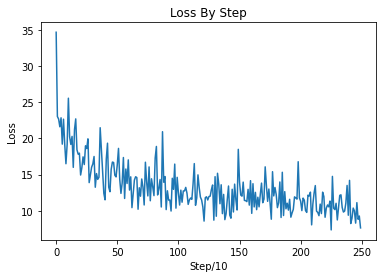

In [35]:
plt.plot(loss_check[::10])
plt.title("Loss By Step")
plt.xlabel('Step/10')
plt.ylabel('Loss')
plt.show()

---

# <span style="background-color:#E6E6FA">  7. 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화 </span>

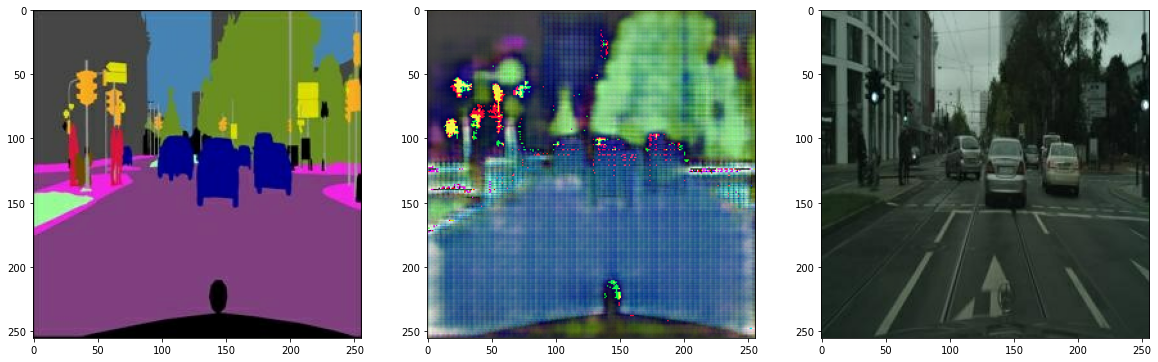

In [33]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind] # "val" 폴더
colored, sketch = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

---

# <span style="background-color:#C0FFFF"> 결과 </span>


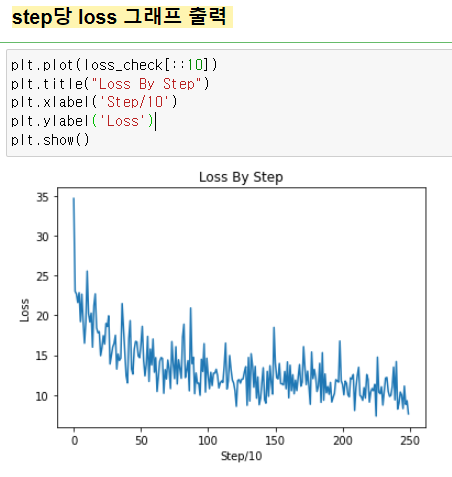 <br/> *프로젝트에서 진행한 loss 그래프* |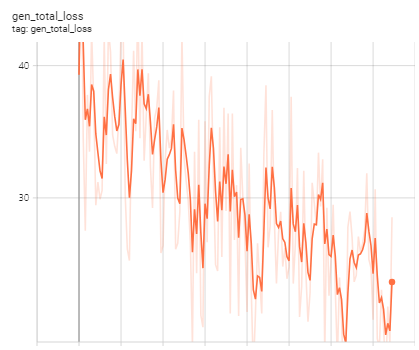  <br/> *텐서 pixtopix https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko *
--- | --- |

위 사진처럼 loss 그래프가 나왔는데 왼쪽은 프로젝트로 진행한 loss이고 오른쪽은 텐서에서 학습을 진행한 loss그래프이다.  
loss 그래프가 굉장히 왔다갔다 하는 것을 볼 수 있는데 처음에는 학습이 잘 안되는 것 같았지만 step이 진행되면서 평균적으로 점점 낮아지는 것을 확인 할 수 있었다.  

<br/>
<br/>
<br/>

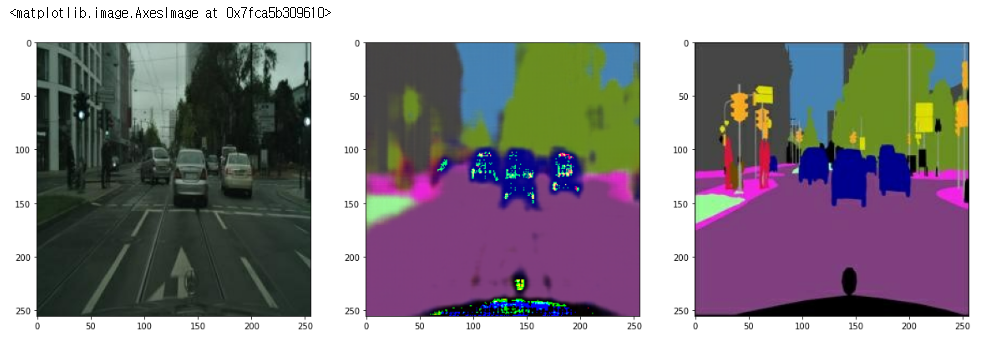 |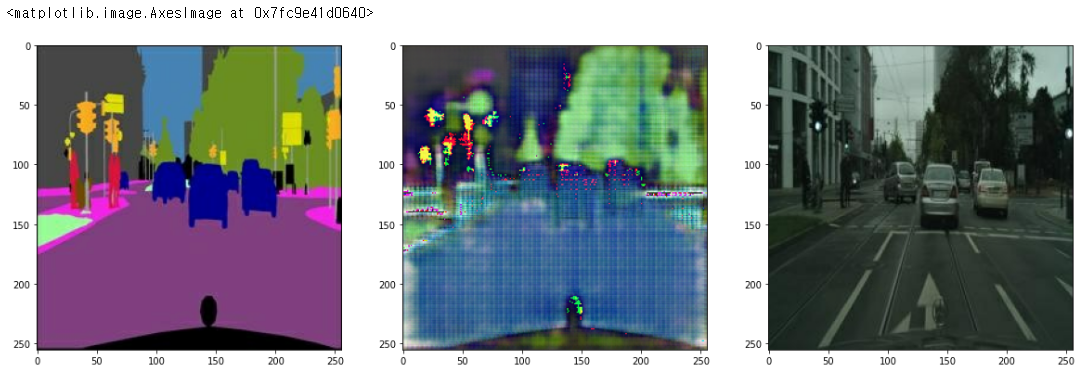
--- | --- |

위 사진은 epoch을 100으로 학습한 모델을 가지고 출력한 이미지인데 스텝으로 약 25000번 진행을 했다고 보면 될 것 같다.  
여기서 위 텐서에서 건물 사진으로 학습을 한 예시가 있는데 그 부분이 최소 step으로 40000번을 학습하는 것을 볼 수 있는데 25000번에 걸맞은 정도의 품질로 나왔다고 볼 수 있을 것 같다.  

노드에서 학습을 진행할 때 포켓몬 사진의 경우 128번 정도에 채색이 어느정도 이루어진 것을 볼 수 있는데 잘 된 이미지는 거의 단색을 띄고 있기 때문일 수도 있을 것 같다.  

위에서 진행한 도로 사진의 경우 더 복잡하기 때문에 이런 결과가 나온 것 같다.  

---

### 추가: 포켓몬 변화

*10번*  
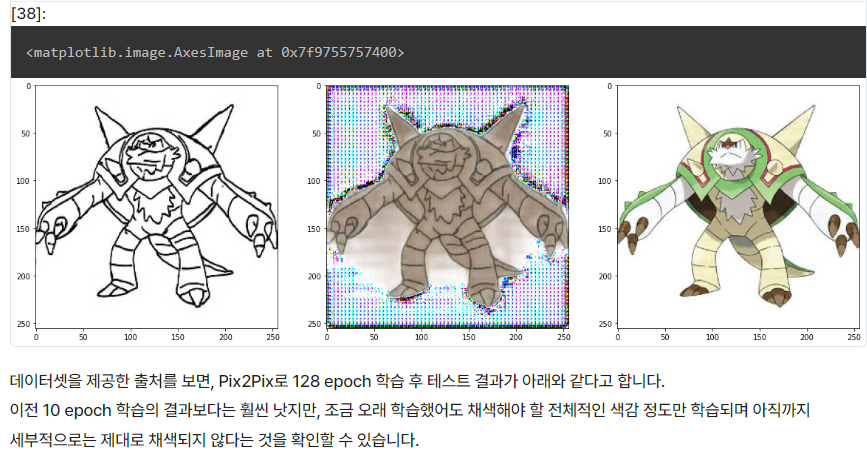  

---

*20번*  
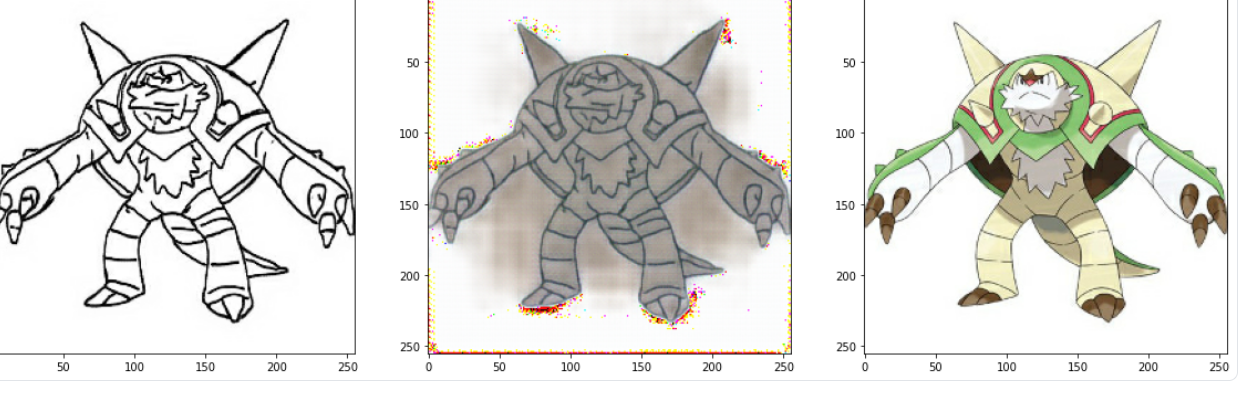  

---

*50번*  
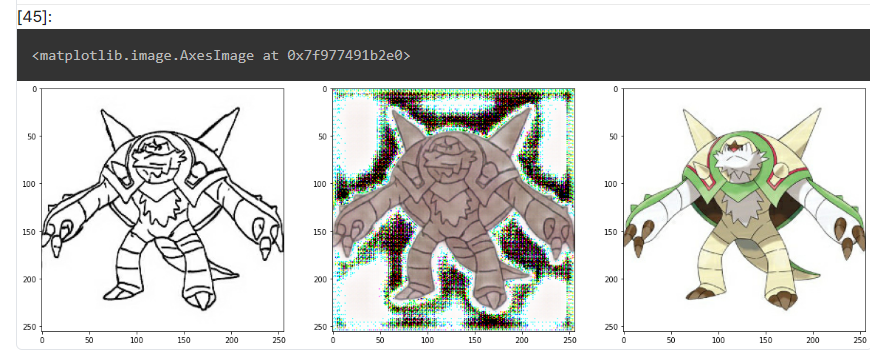  

---

*80번*  
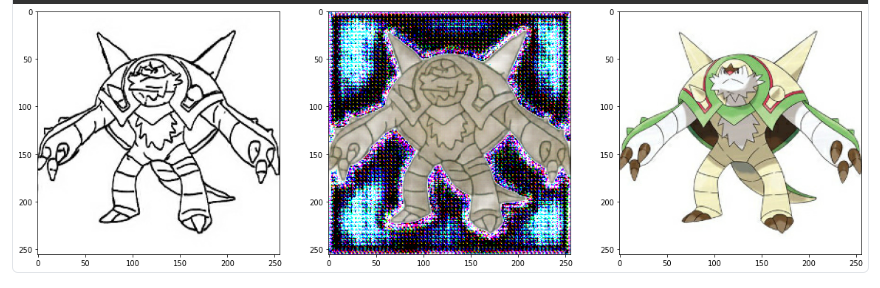

---

*110번*  
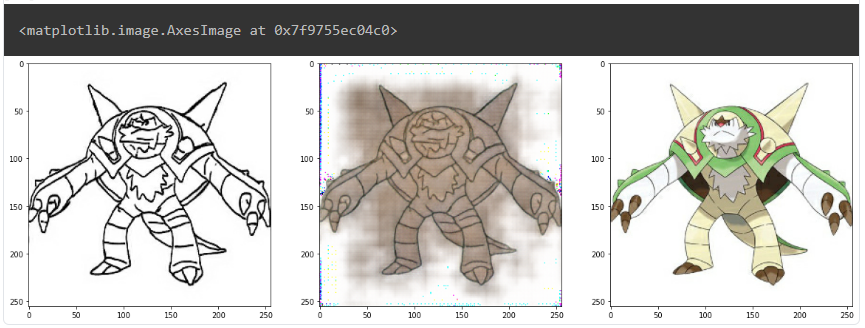

---

*110번 이후 어딘가*  

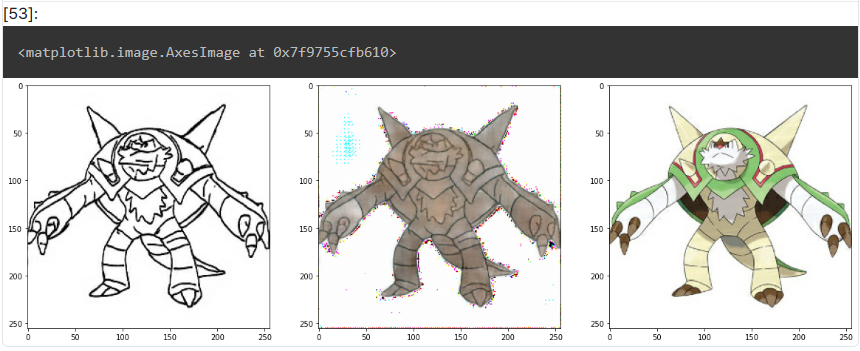

---

# <span style="background-color:#C0FFFF"> 회고 </span>

~~이번 프로젝트를 진행하면서 확실하게 느낀점은 이미지 관련 프로젝트가 재미가 있다는....~~

이번 프로젝트를 진행하고 다양한 인코더를 알게 되었고 초반에 공부했던 이미지넷에서 보던 skip connection을 적용해서 더 나은 결과물이 나오는 것을 보면서 이러한 시도들이 모델을 더 최적화 시키는구나 라고 생각하게 되었다.  

어려운점 & 해결: 처음에 학습이 잘 되지 않는 것처럼 보여서 노드를 천천히 다시 읽어보니 get_gen_loss부분에서 total_loss가 적혀있지는 않은 것을 볼 수 있었는데 그 값을 추가 후에 gradient 계산하는 param으로 넣어주니 학습이 되는 것을 볼 수 있었다. 

그리고 여원님이 gpu사용하는 것을 디스코드에 올려주셔서 다음 프로젝트에는 적용해서 진행해 봐야겠다. - epoch 돌아가는 속도가 굉장히 빨라짐..(신기)